In [76]:
import pandas as pd

data1 = './data/data.csv'

# Remove some languages from the data
drop_list = ['vi', 'ja', 'zh', 'ar', 'ru', 'tr', 'el', 'bg', 'th', 'ur']

df = pd.read_csv(data1)
df = df[~df['labels'].isin(drop_list)]
df.head()

,labels,text
0,nl,Een man zingt en speelt gitaar.
1,nl,De technologisch geplaatste Nasdaq Composite I...
2,es,Es muy resistente la parte trasera rÃ­gida y l...
3,it,"""In tanti modi diversi, l'abilitÃ artistica d..."
7,nl,Verschillende mensen op motorfietsen op een ma...


In [77]:
print(len(df))

45000


In [78]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [79]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
def optimize(X_train, X_test):
    best_score = 0
    best_alpha = 0.1
    # Get the best alpha for the Model
    # This can need some time
    alphas = np.arange(0.01, 1, 0.01)
    l = len(alphas)
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 100)
    progress = 0
    for i in alphas: 
        printProgressBar
        model = MultinomialNB(alpha=i)
        model.fit(X_train, y_train)
        current_score = model.score(X_test, y_test)
        if current_score > best_score:
            best_score = current_score
            best_alpha = i
        progress += 1
        printProgressBar(progress, l, prefix = 'Progress:', suffix = 'Complete', length = 100)
    return (best_score, best_alpha)

In [80]:
X = df["text"]
y = df["labels"]

In [81]:
# CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

cv = CountVectorizer(min_df = 0.001, max_df = 0.25)
X_cv = {
    "train": cv.fit_transform(X_train),
    "test": cv.transform(X_test),
}

In [82]:
# TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

tfidf = TfidfVectorizer(min_df=0, max_df = 0.25, use_idf=True,stop_words='english')

X_tfidf = {
    "train": tfidf.fit_transform(X_train),
    "test": tfidf.transform(X_test),
}

In [83]:
# Compare TfidfVectorizer with CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

best_score_cv, best_alpha_cv = optimize(X_cv['train'], X_cv['test']) # Progress 1
best_score_tfidf, best_alpha_tfidf = optimize(X_tfidf['train'], X_tfidf['test']) # Progress 2
print(best_score_cv, best_score_tfidf)

Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
Progress: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
0.10453333333333334 0.9935111111111111


In [84]:
# Create Model with the tfidf data
model = MultinomialNB(alpha=best_alpha_tfidf)
model.fit(X_tfidf['train'], y_train)

MultinomialNB(alpha=0.23)

In [85]:
# Test
test = ["Hi, wie geht es dir?"]
for val in test:
    val = ''.join(e for e in val if e.isalnum() or e.isspace())
print(val)
print(model.predict(tfidf.transform(test)))

Hi wie geht es dir
['de']


In [86]:
#export
import pickle
import os

if (not os.path.isdir("./models")):
    os.mkdir("./models")

# Dump the Model to use it later
filename = './models/model_mnb_lang_detect.sav'
pickle.dump(model, open(filename, 'wb'))
# Dump the Vectorizer to use it later
filename = './models/tfidf_lang_detect.sav'
pickle.dump(tfidf, open(filename, 'wb'))

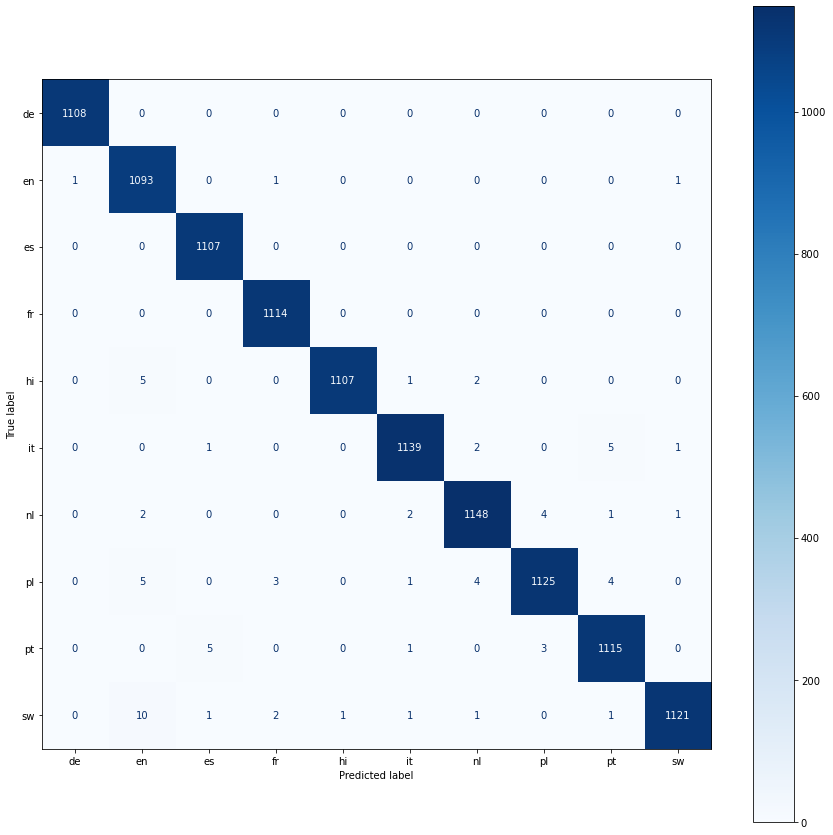

In [87]:
# Visualize
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

y_test_pred = model.predict(X_tfidf['test'])
plot_confusion_matrix(model, X_tfidf['test'], y_test, ax=ax, cmap='Blues')